# Breakthrough Listen RAW Data Format

The Green Bank Ultimate Pulsar Processing Instrument (GUPPI) was one of the main backends for Green Bank Radio Telescopes. Data -- channelized, complex voltages as a function of time -- was stored in the GUPPI RAW data format. The GUPPI RAW format is the inspiration for the Breakthrough Listen RAW data format. 

BL RAW files generally have the following qualities:

* About 17.2 GB
* About 22.8 seconds of observation
* Written in a series of Header Data Units (HDU)
* Header: ASCII text with metadata information
* Data Block: Binary data recording complex, channelized voltages as a function of time

RAW data files are the largest data product provided by a radio telescope.


### About this Tutorial

This tutorial is intended to increase users comfort with RAW data files. Users should be comfortable with Python, Numpy, Jupyter, and familiar with radio astronomy concepts. 

Note, this is not the unique way to parse RAW data. For ease of following along, the Python scripts are developed using a simple read-in, analyze format. More complicated methods using Object Oriented Programming can be used to analyze RAW data as well.


### Getting the Data

Breakthrough Listen aims to make data as publicly available as possible. By going to the following site, you can download as much data as desired:

https://breakthroughinitiatives.org/opendatasearch

On this site, you can specify the project, target, right ascension, declination, time, or center frequency of your desired observation. None need to be specified. By searching with no parameters, you should get something like the following:


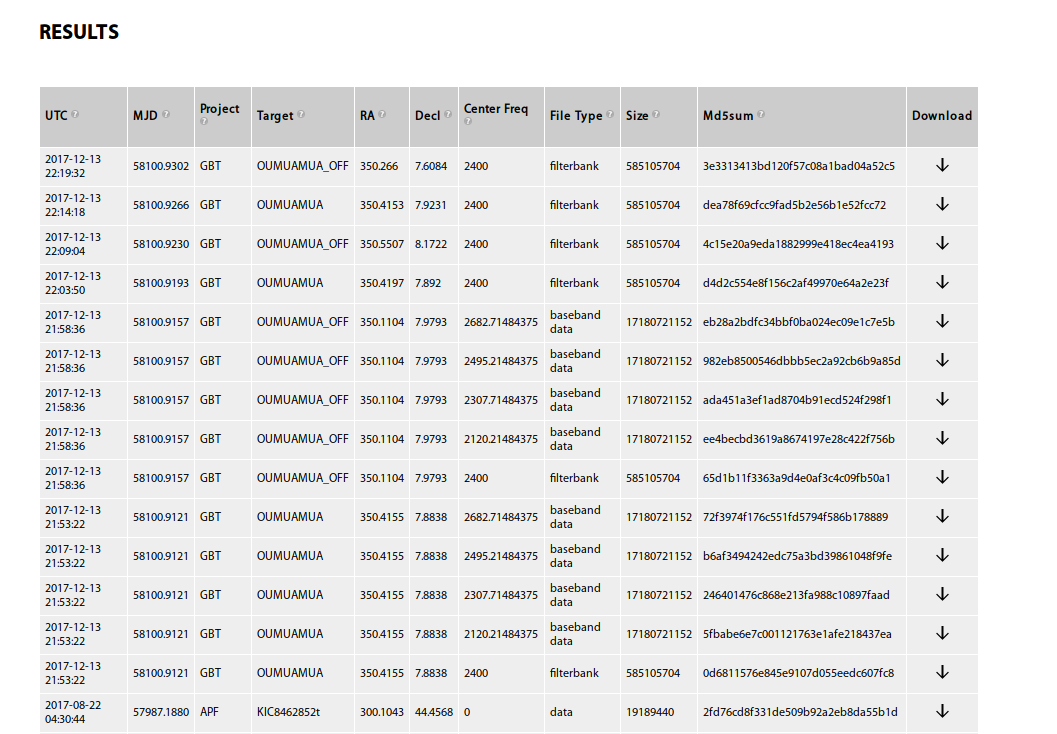

In [2]:
from IPython.display import Image
Image(filename='../ScreenOfData.png')

### File Types

As you can see, there are multiple file types: filterbank, baseband data, and data. For this tutorial, we are interested in the *baseband data* file type. Any of the baseband data files will be sufficient for this tutorial. For clarity, I chose the OUMUAMUA, Center Freq. = 2120.21484375 file.

Click the download button in the far right column. Be patient.

**NOTE:** Be sure that you have enough space on your hard drive. These are large files (~17 GB). If you do not have the space, or Internet speed, please just follow along the rest of the tutorial.

### Header Information

BL RAW data is written in a series of HDUs. The ASCII text header contains the relevant metadata. It is very important that the header is parsed correctly. Otherwise, the binary data block will read incorrectly. 

The header section is written in a series of 80 ASCII character "cards" (sometimes referred to as a record).

The first 8 characters of each card represent the keyword. If the keyword is greater than 8 characters, the keyword is truncated. If the keyword is less than 8 characters, it will be padded with spaces. The 9th and 10th characters are an equals sign and a space character, respectively. The remaining characters are filled with the value of the keyword (and spaces).


A final note about the header section is its completion. The header section contains information to inform the user when the header file is finished and the data block is about to start. This is accomplished with the keyword END followed by 77 space characters.

In [8]:
import numpy as np
import os

#File Information
inputFileName = "../../Downloads/blc05_guppi_58100_78802_OUMUAMUA_0011.0000.raw"
readIn = np.memmap(inputFileName, dtype = 'int8', mode = 'r')
fileBytes = os.path.getsize(inputFileName)

cardLength = 80     #BL Raw Information

#Ensure the same card is not read twice
lineCounter = 0     
currentBytesPassed = 0


headerLoop = True
while(headerLoop):
    
    cardString = ''
    
    #Get the ASCII value of the card and convert to char
    for index in range(cardLength):
        cardString += chr(readIn[currentBytesPassed + index + lineCounter * cardLength])

    print(cardString)

    # Reached end of header
    if (cardString[:3] == 'END'):
        headerLoop = False
  
    lineCounter += 1    #Go to Next Card in Header


BACKEND = 'GUPPI   '                                                            
DAQCTRL = 'start   '                                                            
DAQPULSE= 'Wed Dec 13 16:53:21 2017'                                            
DAQSTATE= 'record  '                                                            
NBITS   =                    8                                                  
OFFSET0 =                  0.0                                                  
OFFSET1 =                  0.0                                                  
OFFSET2 =                  0.0                                                  
OFFSET3 =                  0.0                                                  
BANKNAM = 'BLP05   '                                                            
TFOLD   =                    0                                                  
DS_FREQ =                    1                                                  
DS_TIME =                   

This list is typical of a RAW file. There are many cards. The following are a list of especially important cards:
* OBSFREQ: The central frequency observed [MHz]
* OBSBW: Observing bandwidth (negative sign indicates spectral flip) [MHz]
* OBSNCHAN: Number of Channels
* NPOL: Number of polarizations (if 4, dual-polarized with real and complex values)
* NBITS: Number of bits per real/imaginary value
* TBIN: Sample period within a channel [seconds]
* BLOCSIZE: The size of the data block in bytes (indicates when the next header will start)
* DIRECTIO: See next section

By placing a conditional in the header loop, one can extract the values of these cards. Something like the following:

In [11]:
if(cardString[:8] == 'OBSNCHAN'): #Number of Channels
    OBSNCHAN = int(cardString[9:].strip()) #remove white spaces and convert to int

### DIRECTIO

BL uses Direct I/O. Direct I/O is a very fast file writer, but adds some requirements. Direct I/O requires that disk writing be a multiple of 512 bytes. Thus, a keyword called “DIRECTIO” in the header indicates a padding offset. This offset occurs after the END + 77 spaces card, but before the data block begins. 

If DIRECTIO is 0 or unlisted, then there is no padding needed. If specified to a non-zero value, then the user must parse from their location until the next location corresponding to a multiple of 512 bytes. The padding byte values are unimportant, but must be skipped before reaching the data block.

### Data Block

The binary data block can be understood as a 3-Dimensional (row-major) array:

**[The number of channels, the number of time samples per channel, the number of polarizations]**

The number of time samples per channel is not given in the header information. We must calculate it for ourselves according to the following equation: NDIM = BLOCSIZE/(OBSNCHAN X NPOL X (NBITS/8))

Thus, the data block is an array indexed by **[OBSNCHAN, NDIM, NPOL]**.

Also, it is important to know that the polarizations cycle according to the following order:

1) x-Real

2) x-Imaginary

3) y-Real

4) y-Imaginary


### Getting the Data Block in Python

Applying what we know, let's get the data block in a usable form in Python.

Starting from the beginning:

In [28]:
import numpy as np
import os

inputFileName = "../../Downloads/blc05_guppi_58100_78802_OUMUAMUA_0011.0000.raw"
readIn = np.memmap(inputFileName, dtype = 'int8', mode = 'r')
fileBytes = os.path.getsize(inputFileName)

cardLength = 80     #BL Raw Information

#Ensure the same card is not read twice
lineCounter = 0     
currentBytesPassed = 0

# Because the files are so large, we are going to run through only the first HDU in this tutorial
blockNumber = 0
while (blockNumber < 1):
   
    # Loop through header information -------------------------------------------------------------------
    headerLoop = True
    lineCounter = 0     #Ensure the same card is not read twice
    while(headerLoop):
    
        cardString = ''

        #Get the ASCII value of the card and convert to char
        for index in range(cardLength):
            cardString += chr(readIn[currentBytesPassed + index + lineCounter * cardLength])

        print(cardString)

        #Identify the end of the header
        #If not the end, find other useful parameters from header
        if (cardString[:3] == 'END'):   #reached end of header
            headerLoop = False

        elif(cardString[:8] == 'OBSNCHAN'): #Number of Channels
            OBSNCHAN = int(cardString[9:].strip()) #remove white spaces and convert to int

        elif(cardString[:4] == 'NPOL'):     #Number of Polarizations * 2
            NPOL = int(cardString[9:].strip())

        elif(cardString[:5] == 'NBITS'):    #Number of Bits per Data Sample
            NBITS = int(cardString[9:].strip())

        elif(cardString[:7] == 'OVERLAP'):  #Number of Time Samples that Overlap Between Blocks
            OVERLAP = int(cardString[9:].strip())

        elif(cardString[:8] == 'BLOCSIZE'): #Duration of Data Block in Bytes
            BLOCSIZE = int(cardString[9:].strip())

        elif(cardString[:8] == 'DIRECTIO'):
            DIRECTIO = int(cardString[9:].strip())

        elif(cardString[:7] == 'OBSFREQ'):
            OBSFREQ = float(cardString[9:].strip())

        elif(cardString[:7] == 'CHAN_BW'):
            CHAN_BW = float(cardString[9:].strip())

        elif(cardString[:5] == 'OBSBW'):
            OBSBW = float(cardString[9:].strip())

        elif(cardString[:4] == 'TBIN'):
            TBIN = float(cardString[9:].strip())

        lineCounter += 1    #Go to Next Card in Header

    # End Header Loop-------------------------------------------------------------------
        
    # Padding Bytes
    if (DIRECTIO != 0):
        DIRECTIO_offset = 512 - (cardLength*lineCounter)%512
    else:
        DIRECTIO_offset = 0

    # Skip Header
    headerOffset = cardLength * lineCounter + DIRECTIO_offset
    currentBytesPassed += headerOffset

    # Number of time samples per channel per block
    NDIM = int(BLOCSIZE/(OBSNCHAN*NPOL*(NBITS/8)))
    print("\nNDIM:", NDIM)

    
    #Put data into an easily parsed array
    dataBuffer = readIn[currentBytesPassed:currentBytesPassed + BLOCSIZE].reshape(OBSNCHAN, NDIM, NPOL)
    
    # Quick example of how to isolate one polarization from one channel
    for CHANNEL in range(OBSNCHAN):
        if (CHANNEL == 0):
            xr = dataBuffer[CHANNEL,:,0]
            xi = dataBuffer[CHANNEL,:,1]
            yr = dataBuffer[CHANNEL,:,2]
            yi = dataBuffer[CHANNEL,:,3]
            
            # At this point, you could run an FFT, periodogram, etc.
            # A simple print statement is sufficient to show it worked
            print("Channel 0, X Real Length:" ,len(xr))
            print("Channel 0, X Imaginary Length:", len(xi))
            print("Channel 0, Y Real Length:", len(yr))
            print("Channel 0, Y Imaginary Length:", len(yi))
    
    # When parsing the entire file, keep track of where you are at
    currentBytesPassed += BLOCSIZE
    blockNumber += 1
  

BACKEND = 'GUPPI   '                                                            
DAQCTRL = 'start   '                                                            
DAQPULSE= 'Wed Dec 13 16:53:21 2017'                                            
DAQSTATE= 'record  '                                                            
NBITS   =                    8                                                  
OFFSET0 =                  0.0                                                  
OFFSET1 =                  0.0                                                  
OFFSET2 =                  0.0                                                  
OFFSET3 =                  0.0                                                  
BANKNAM = 'BLP05   '                                                            
TFOLD   =                    0                                                  
DS_FREQ =                    1                                                  
DS_TIME =                   

## Discussion

**Congratulations!** If you have made it this far, then you are on your way to becoming a BL RAW file expert. This is no small feat; BL RAW files are cutting edge file types developed for the massive amounts of data coming from a radio telescope!

Remember, a RAW file is a series of HDUs where the binary data block can be understood as a 3-D Array.

At this point, the following figure should make sense. Specific byte values may vary slightly from RAW file to RAW file, but the outline remains the same. The byte values of this figure reflect the same file used during the tutorial.

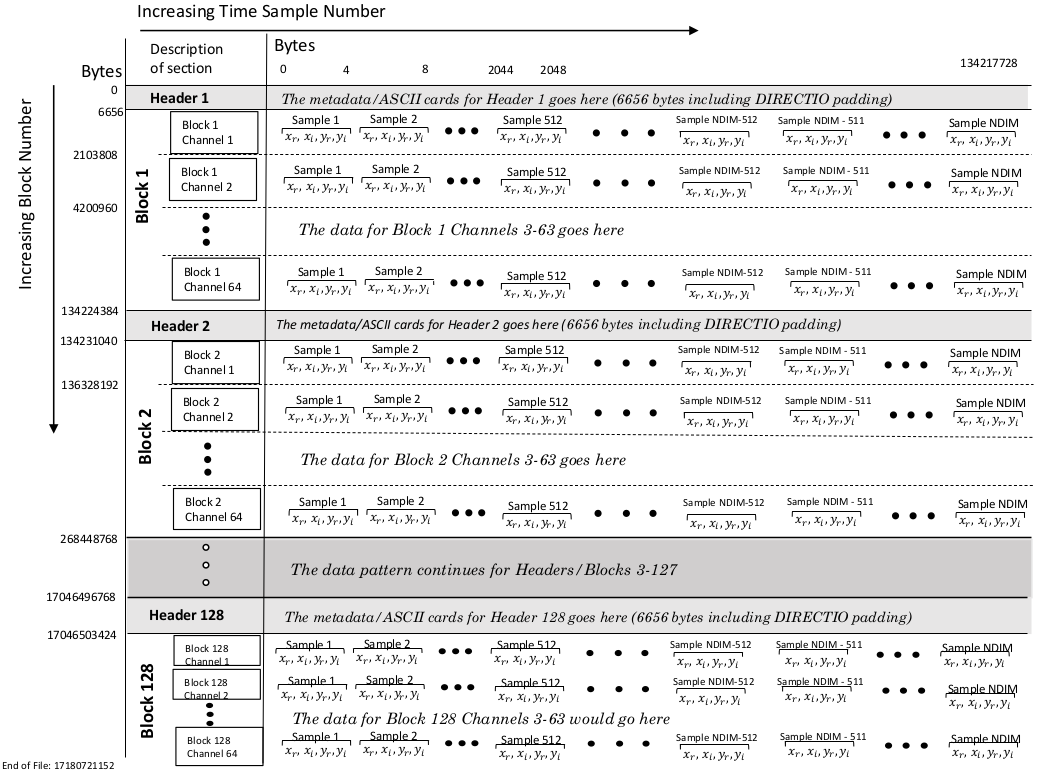

In [26]:
from IPython.display import Image
Image(filename='../RAW_File.png')